# MLOps w praktyce @ SKNI

## Tomasz Adamczyk



Cześć! W tym notebooku znajdziecie cały kod jaki omówiliśmy na pierwszym spotkaniu MLOps w praktyce 8 grudnia.
W razie pytań piszcie maile, coś wymyślimy :)

# Instalacja MLflow

Mlflow dostępny jest na Windowsa, macOSa, jak i systemy Linuksowe. Osobiście polecam pobawienie się jakąś dystrybucją linuksa. Idąc w stronę MLOpsową, czy DevOpsową na pewno prędzej, czy później się z nim spotkacie, a i Python jest mniej upierdliwy na linuksach :)

Na początek wystaczy maszyna wirtualna. Dobry tutorial jej postawienia znajdziecie na stronie Ubuntu: https://ubuntu.com/tutorials/how-to-run-ubuntu-desktop-on-a-virtual-machine-using-virtualbox#1-overview

Niezależnie od systemu na jakim będziecie działać potrzebujecie Pythona. Na Linuksach zainstalowany będzie defaultowo. Na Windowsie trzeba samemu do ogarnąć. Pamiętajcie, że żeby Python był widoczny z konsoli musicie dodać ściężkę do niego do zmiennej środowiskowej PATH. Wszystko wyjaśni ten tutorial: https://www.digitalocean.com/community/tutorials/install-python-windows-10

Po zainstalowaniu Pythona już jest z górki. MLflow można pobrać przy użyciu pythonowego pip

python -m pip install mlflow

Jeśli chcecie mieć także dostęp do "Model Registry" musicie postawić lokalną bazę danych. Sqlite w zupełności wystarczy. Do wykonania pracy domowej tego nie potrzeba, ale zachęcam.

Dokumentacja MLflow tutaj: https://mlflow.org/docs/latest/quickstart.html#

# Uruchomienie MLflow

MLflow uruchomicie z poziomu konsoli wpisując: 

mflow ui

lub jeśli macie postawioną bazę:

mlflow server --backend-store-uri sqlite:///skni.sqlit

gdzie skni.sqlit jest nazwą bazy, z której będziemy korzystać. 


![](img/1.png)

Po przejściu na adres podany po uruchomieniu (0.0.0.0:5000) powinniśmy zastać taki widok.
![](img/2.png)

# UWAGA DLA WINDOWSA
Aby artifacts zapisywały się poprawnie mlflow musi zostać uruchomiony w folderu "mlruns". O problemie możecie poczytać tutaj: https://github.com/mlflow/mlflow/issues/3030
Na Ubuntu nie spotkałem się z tym problemem.

# Tracking

## MLowy hello world
Zacznijmy od MLowego "Hello worlda". Zaimportujmy jakiś dataset, podzielmy go na zbiór uczący i zbiór testowy, wytrenujmy model i przetestujemy go.

In [39]:
from sklearn import datasets

data = datasets.load_iris()

data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [40]:
# Podzielmy zbiór na zbiór uczący i testowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], random_state=0)

In [41]:
# Wybierzmy model i wytrenujmy go
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=1, max_depth=3, max_leaf_nodes=2)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_leaf_nodes=2, n_estimators=1)

In [42]:
# Sprawdźmy accuracy
acc = forest_clf.score(X_test, y_test)
print(f"Accuracy of the DecisionTreeClassifier: {acc:.1%}")

Accuracy of the DecisionTreeClassifier: 57.9%


"Hello world" za nami. Teraz fajnie było porobić więcej eksperymentów, a żeby ułatwić sobie ich monitorowanie użyjmy MLflow.

## Połączmy się z MLflow

Aby móc wykorzystywać MLflow w naszych skryptach musimy zacząć od zaimportowania bibliotek.
Pierwsza z nich to API do komunikacji z serwisem, a druga jest wrapperem na moduł scikit-learn.

In [43]:
import mlflow
import mlflow.sklearn

Na początek podajemy adres naszego serwisu. Działamy lokalnie, więc adres to 0.0.0.0 (lub localhost, lub 127.0.0.1 - w zasadzie jedno i to samo). Defaultowy port na jakim ruszy MLflow to 5000.

In [44]:
remote_server_uri = "http://0.0.0.0:5000"
mlflow.set_tracking_uri(remote_server_uri)

Upewnijmy się jeszcze, czy adres został zapisany

In [45]:
mlflow.tracking.get_tracking_uri()

'http://0.0.0.0:5000'

## Tworzenie eksperymentu
Nasz skrypt wie już, gdzie może znaleźć serwis. Zatem stwórzmy eksperyment o nazwie "iris". W nim zapisywane będą wyniki kolejnych runów. 

In [46]:
from mlflow.exceptions import RestException

try:
    exp_name = "iris"
    mlflow.create_experiment(exp_name)
except RestException:
    print('Experiment {} already exists!'.format(exp_name))

Po tym kroku eksperyment powinien być widoczny jak poniżej.
![](img/3.png)


## Śledzenie runów
Mając utworzony eksperyment, możemy zacząć trenować modele i zapisywać rezultaty. Zacznijmy od zapisania accuracy naszego modelu.

Na początek musimy wyspecyfikować eksperyment, który będziemy wykonywać - set_experiment("iris").

Dalej uruchamiany run - w założeniu jeden run to jeden trening i jeden test modelu. Runy nie muszą się różnić, ale dążymy do tego, żeby każdy run odnosił się np. do innego datasetu, innych hiperparametrów modelu, czy zupełnie innej metody uczenia. Do wystartowania runu używamy metody sart_run(). Uruchamiamy ją w ramach managera kontekstu (context manager), aby mieć pewność, że w razie problemów wszystkie procesy związane z MLflow zostaną domknięte.

Dalej podobnie jak w przypadku naszego "hello world" pobieramy dataset, dzielimy go i trenujemy model

In [47]:
mlflow.set_experiment(exp_name) 
with mlflow.start_run() as run:
    print("Run: {}".format(run.info.run_id))

    data = datasets.load_iris()
    X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], random_state=0)

    forest_clf = RandomForestClassifier(n_estimators=5, max_depth=3, max_leaf_nodes=4)
    forest_clf.fit(X_train, y_train)

    acc = forest_clf.score(X_test, y_test)

    print(f"Accuracy: {acc:.1%}")


Run: d7853efb6371415ab1ad87e09fbf742a
Accuracy: 89.5%


Po uruchomieniu tego kodu nasz run zostaje zapisany w ramach eksperymentu "iris". Ma on swoją nazwę, informacje o czasie trwania i czasie utworzenia, ale poza tym niewiele się dzieje.
![](img/4.png)
![](img/5.png)


## Logowanie parametrów i wyników modeli
"Hello MLflow" za nami. Przejdźmy do zapisywania informacji o kolejnych runach. W mlflow możemy zapisywać parametry modeli, ich rezultaty (accuracy, precision, recall itd.), inne artefakty (kod źródłowy, wykresy, zbiory danych - w zasadzie cokolwiek).

Poniżej wytrenujemy model i zapiszemy jego parametry, i wynik accuracy na naszym zbiorze testowym.
Dzięki metodzie log_params(), przyjmującej jako argument słownik z parametrami, zapiszemy hiperparametry tego modelu, a dalej przy użyciu log_metric zapiszemy wartość jego accuracy.

In [48]:
mlflow.set_experiment(exp_name)
with mlflow.start_run() as run:
    print("Run: {}".format(run.info.run_id))
    n_estimators = 3
    max_depth = 3
    max_leaf_nodes = 2
    
    mlflow.log_params( 
        {"n_estimators": n_estimators,
         "max_depth": max_depth, 
         "max_leaf_nodes": max_leaf_nodes}
    )
    
    data = datasets.load_iris()
    X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], random_state=0)
    
    
    forest_clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        max_leaf_nodes=max_leaf_nodes)
    
    forest_clf.fit(X_train, y_train)

    acc = forest_clf.score(X_test, y_test)
    mlflow.log_metric("test_acc", acc) 
    print(f"Accuracy: {acc:.1%}")



Run: a318c35ee93d4d2183a42ca3a1c1cc2c
Accuracy: 89.5%


Eksperyment się wykonał i podstawowe dane wyświetlone są na stronie głównej. Dzięki temu możemy dokonać podstawowej analizy naszych modeli filtrując je po którejś z kolumn.
![](img/6.png)

Podobnie są one widoczne dalej po wejściu w run.
![](img/7.png)


## Artefakty
W ramach runu możemy zapisywać dowolne obiekty powiązane z naszymi badaniami. Do tego wykorzystujemy metodę log_artifact. Pozwala ona na zapisanie dowolnego pliku, do którego ścieżkę podamy. Poniżej zapiszemy jako artefakt ten notebook, oraz jakiś przypadkowy wykres - wyobraźmy sobie, że jest dla nas superważny :) 

UWAGA aby plik dało się zapisać jako artefakt, musi on znajdować się w systemie plików. Dlatego poniższy wykres najpierw zapisujemy jako "figure.png" i dopiero następnie logujemy jako artefakt.


Run: 3fef46305b1b425f9dbb9ad5a1d26537
Accuracy: 94.7%


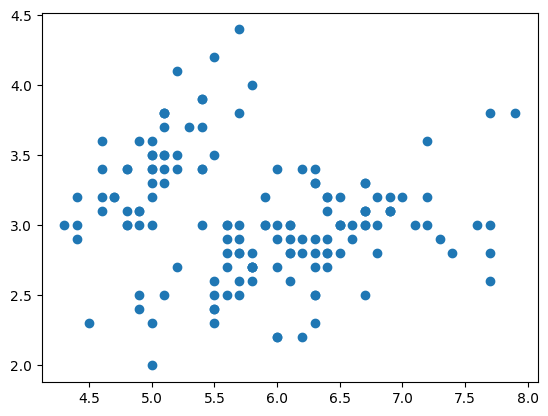

In [49]:
import matplotlib.pyplot as plt

mlflow.set_experiment(exp_name)
with mlflow.start_run() as run:
    print("Run: {}".format(run.info.run_id))
    n_estimators = 3
    max_depth = 3
    max_leaf_nodes = 2
    
    mlflow.log_params( 
        {"n_estimators": n_estimators,
         "max_depth": max_depth, 
         "max_leaf_nodes": max_leaf_nodes}
    )
    
    data = datasets.load_iris()

    X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], random_state=0)
        
    
    forest_clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        max_leaf_nodes=max_leaf_nodes)
    
    forest_clf.fit(X_train, y_train)

    acc = forest_clf.score(X_test, y_test)
    mlflow.log_metric("test_acc", acc)
    
    mlflow.log_artifact("MLflow@skni.ipynb")
    print(f"Accuracy: {acc:.1%}")

    plt.plot(data['data'][:,0], data['data'][:,1], 'o')
    plt.savefig("figure.png")
    mlflow.log_artifact("figure.png")


Po wejściu w run widać nasze pierwsze artefekaty - kopię notebooka i wykres.
![](img/8.png)


## Modele 
Co jeszcze warto zapisywać? Oczywiście modele. Dzięki śledzeniu poprzednich kroków nie mielibyśmy problemu z odtworzeniem modelu z dowolnego runa, ale po co dwa razy robić to samo. Zapiszmy do zatem.

W przeciwieństwie do artefaktów, modeli nie musimy najpierw zapisywać w systemie plików. Wystarczy wywołać metodę log_model(), w której poodajemy obiekt modelu (tutaj forest_clf) i nazwę pod jaką chcemy go ukryć.

Run: 5e1413403e814121aaeab766ebf96866
Accuracy: 97.4%


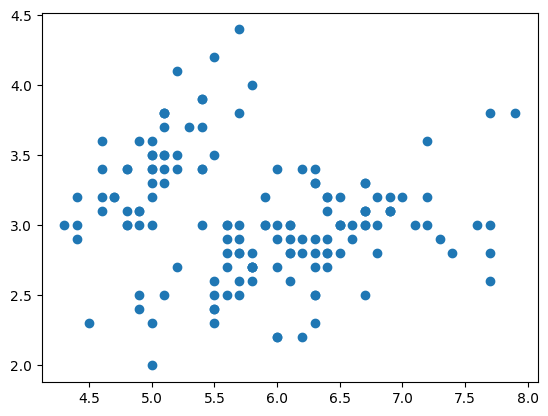

In [50]:
import matplotlib.pyplot as plt

mlflow.set_experiment(exp_name)
with mlflow.start_run() as run:
    print("Run: {}".format(run.info.run_id))
    n_estimators = 10
    max_depth = 20
    max_leaf_nodes = 10
    
    mlflow.log_params( 
        {"n_estimators": n_estimators,
         "max_depth": max_depth, 
         "max_leaf_nodes": max_leaf_nodes}
    )
    
    data = datasets.load_iris()

    X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], random_state=0)
        
    
    forest_clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        max_leaf_nodes=max_leaf_nodes)
    
    forest_clf.fit(X_train, y_train)

    acc = forest_clf.score(X_test, y_test)
    mlflow.log_metric("test_acc", acc)
    
    mlflow.log_artifact("MLflow@skni.ipynb")
    print(f"Accuracy: {acc:.1%}")

    plt.plot(data['data'][:,0], data['data'][:,1], 'o')
    plt.savefig("figure.png")
    mlflow.log_artifact("figure.png")

    mlflow.sklearn.log_model(forest_clf, "forest_clf_model")


Po zapisaniu modelu widoczny jest on już na stronie głównej.
![](img/9.png)


A więcej informacji znajdziemy w sekcji "Artifacts". Poza samym modelem zapisane zostają także pewne metadane na jego temat, takie jak biblioteki wykorzystane do jego utworzenia i zapisania.

![](img/10.png)


## Model schema
Zapisując model możemy także zapisać informacje o tym jakie są jego dane wejściowe i wyjściowe - jest to szczególnie potrzebne jeśli chcemy wykonać deploy modelu z poziomu MLflow. Używamy do tego klasy Schema, której podajemy nazwy danych jakie może przyjmować model wraz z ich typami danych. Tak utworzone obiekty dla wejścia i wyjścia modelu zamykamy w ramach obiektu "ModelSignature", który podajemy w metodzie log_model.


In [51]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
  ColSpec("float", "sepal length (cm)"),
  ColSpec("float", "sepal width (cm)"),
  ColSpec("float", "petal length (cm)"),
  ColSpec("float", "petal width (cm)"),

])
output_schema = Schema([ColSpec("integer")])

signature = ModelSignature(inputs=input_schema, outputs=output_schema)


Run: bf519a69062d4da0a15e24d29d505337
Accuracy: 97.4%


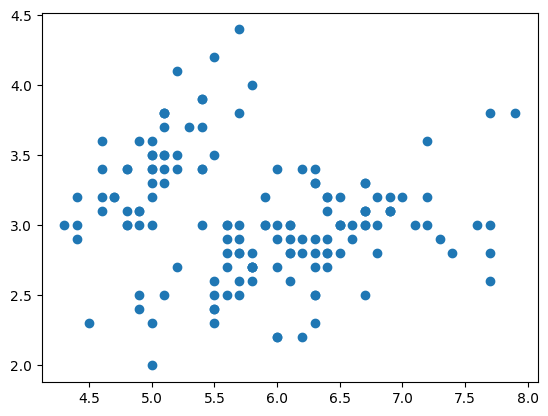

In [52]:
import matplotlib.pyplot as plt

mlflow.set_experiment(exp_name)
with mlflow.start_run() as run:
    print("Run: {}".format(run.info.run_id))
    n_estimators = 3
    max_depth = 3
    max_leaf_nodes = 2
    
    mlflow.log_params( 
        {"n_estimators": n_estimators,
         "max_depth": max_depth, 
         "max_leaf_nodes": max_leaf_nodes}
    )
    
    data = datasets.load_iris()

    X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], random_state=0)
        
    
    forest_clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        max_leaf_nodes=max_leaf_nodes)
    
    forest_clf.fit(X_train, y_train)

    acc = forest_clf.score(X_test, y_test)
    mlflow.log_metric("test_acc", acc)
    
    mlflow.log_artifact("MLflow@skni.ipynb")
    print(f"Accuracy: {acc:.1%}")

    plt.plot(data['data'][:,0], data['data'][:,1], 'o')
    plt.savefig("figure.png")
    mlflow.log_artifact("figure.png")

    mlflow.sklearn.log_model(forest_clf, "forest_clf_model", signature=signature)


Informacje o "schemacie" modelu zapisane zostają jako metadane modelu.
![](img/11.png)


## Wiele eksperymentów
Wiedząc już jak budować eksperymenty, logować parametry, wartości metryk i same modele przejdźmy do "masowego" eksperymentowania. Załóżmy, że chcemy przetestować jak nasza wybrana metoda poradzi sobie w zależności od pewnych hiperparametrów. Żeby przeprowadzić taki eksperyment musimy przygotować strukturę danych, w której te hiperparametry umieścimy.

Zaczynamy od zbudowania listy, która zawiera listy hiperparametrów. Przechodzimy przez każdą z nich, trenujmy model zgodnie z parametrami jakie w każdej z nich się znajdują i zapisujemy wszystkie dane tak jak robiliśmy wcześniej. Dzięki temu zautomatyzowaliśmy proces wykonywania wielu runów.

Run: 6e3b9b20697b44a1bfdbe50f68bfb2de
Accuracy: 97.4%
Run: c5a697b6f1f54a19abf5cc47a097a1c7
Accuracy: 97.4%
Run: 0aab8de8a4bb47a087d91c710a078f10
Accuracy: 97.4%


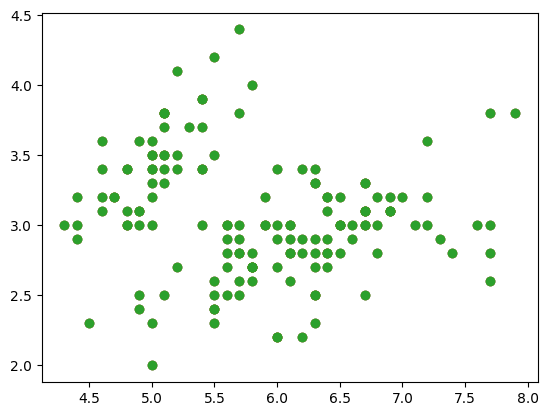

In [53]:
list_of_params = [[3, 3, 3],
                 [4, 4, 4],
                 [5, 5, 6]]
mlflow.set_experiment(exp_name)
for params in list_of_params:

    with mlflow.start_run() as run:
        
        print("Run: {}".format(run.info.run_id))
        n_estimators = params[0]
        max_depth = params[1]
        max_leaf_nodes = params[2]

        mlflow.log_params( 
            {"n_estimators": n_estimators,
             "max_depth": max_depth, 
             "max_leaf_nodes": max_leaf_nodes}
        )

        data = datasets.load_iris()

        X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], random_state=0)


        forest_clf = RandomForestClassifier(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            max_leaf_nodes=max_leaf_nodes)

        forest_clf.fit(X_train, y_train)

        acc = forest_clf.score(X_test, y_test)
        mlflow.log_metric("test_acc", acc)

        mlflow.log_artifact("MLflow@skni.ipynb")
        print(f"Accuracy: {acc:.1%}")

        plt.plot(data['data'][:,0], data['data'][:,1], 'o')
        plt.savefig("figure.png")
        mlflow.log_artifact("figure.png")

        mlflow.sklearn.log_model(forest_clf, "forest_clf_model", signature=signature)

Jak widać nasze trzy modele zostały wytrenowane. 
![](img/12.png)
Możemy teraz dokonać ich analizy zaznaczając wszystkie runy i przechodząc do compare. 

![](img/13.png)
Tam możemy zwizualizować rezultaty i przeanalizowąć wykonany eskperyment.

![](img/14.png)




## Pobieranie modelu do predykcji
Zrobiliśmy analizę, teraz chcemy dokonać predykcji. Aby wyciągnąć model z MLflow wystarczy użyć metody mlflow.sklearn.load_model(), której podajemy ścieżkę do naszego modelu. Podajemy  w niej "Run ID" runa, z którego chcemy wyciągnąć model, oraz nazwę, pod którą go zapisaliśmy. Dalej możemy dokonać predykcji w oparciu o metodę predict dokładnie tak jak robi się to w bibliotece scikit-learn.

In [55]:
logged_model = 'runs:/0aab8de8a4bb47a087d91c710a078f10/forest_clf_model'
loaded_model = mlflow.sklearn.load_model(logged_model)
loaded_model.predict([[1.1, 2.3, 2.3, 2.3],
                     [0.1, 0.3, 0.3, 1.3],
                     [1.7, 1.9, 4.3, 3.3]])

array([1, 1, 1])

# Deploy
## UWAGA
Do tego potrzebujemy postawionej bazy danych, zatem traktujemy to jako dodatek.

MLflow pozwala nam na deploy modelu, dzięki czemu nie musimy bawić się w budowanie dodatkowego serwisu do jego serwowania. Do zrobienia tego musimy najpierw utworzyć rejestr (create_registered_model), w którym będą trzymane kolejne wersje modeli, a następne zapisać w nim model z wybranego runa (register_model).


In [56]:
import mlflow

remote_server_uri = "http://0.0.0.0:5000"
mlflow.set_tracking_uri(remote_server_uri)

In [57]:
from mlflow.tracking import MlflowClient
from mlflow.exceptions import RestException

model_name = "iris_clf"

client = MlflowClient()
try:
    registered_model = client.create_registered_model(model_name)
    print(registered_model)
except RestException:
    print('Model {} already exists!'.format(exp_name))

<RegisteredModel: creation_timestamp=1672319771139, description='', last_updated_timestamp=1672319771139, latest_versions=[], name='iris_clf', tags={}>


In [58]:
run_id = "0aab8de8a4bb47a087d91c710a078f10"

result = mlflow.register_model(
    f"runs:/{run_id}/forest_clf_model",
    f"{model_name}"
)

Registered model 'iris_clf' already exists. Creating a new version of this model...
2022/12/29 14:16:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: iris_clf, version 1
Created version '1' of model 'iris_clf'.


Rejestr został utworzony:
![](img/15.png)

A w nim znajduje się nasz model gotowy do deployu.
![](img/16.png)

Teraz możemy uruchomić quasi-serwis, dzięki któremu przez żądania HTTP będziemy dokonywać predykcji (np. w aplikacji webowej, którą możemy dobudować).

Aby uruchomić taki serwis w konsoli uruchamiamy komendę:

MLFLOW_TRACKING_URI=http://localhost:5000 mlflow models serve --env-manager=local -m "models:/iris_clf/1" -p 4242

w której podajemy nazwę rejestru z jakiego chcemy zaserwować model, wersję modelu, oraz port pod jakim model będzie lokalnie dostępny.

![](img/17.png)

Dalej możemy wysłać żądanie HTTP pod adres na jakim model się znajduje i dokonać predykcji.


In [59]:
import json
import requests
from requests.structures import CaseInsensitiveDict

url = "http://127.0.0.1:4242/invocations"


headers = CaseInsensitiveDict()
headers["Content-Type"] = "application/json"

data = {"instances": [
        {"sepal length (cm)": 1.1, "sepal width (cm)": 1.1, "petal length (cm)": 1.1, "petal width (cm)": 1.2}
    ]
    }

response = requests.post(url, headers=headers, data=json.dumps(data))
print(response.content)

b'{"predictions": [1]}'
